# Objective I: Automated Parallel Corpus Generation

This notebook will create a parallel corpus for scientific translation by:

1. Collecting article metadata from the [OpenAlex](https://openalex.org/) Database
2. Automatically download the raw PDFs
3. Convert PDFs to markdown (preserving layout)
4. Filter by language


### Configuration


In [1]:
LANGUAGES = {
    "ta": {"name": "Tamil", "max_articles": 10, "target_sentences": 100},
    "bn": {"name": "Bengali", "max_articles": 10, "target_sentences": 100},
    "th": {"name": "Thai", "max_articles": 10, "target_sentences": 100},
    "sw": {"name": "Swahili", "max_articles": 10, "target_sentences": 100},
    "et": {"name": "Estonian", "max_articles": 10, "target_sentences": 100},
}

### Imports and Setup


In [13]:
import re
import json
import time
import pymupdf
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display

import spacy
import pymupdf4llm
from lingua import LanguageDetectorBuilder

import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait


In [18]:
DATA_DIR = Path.cwd() / "data"
METADATA_DIR = DATA_DIR / "metadata"
PDFS_DIR = DATA_DIR / "pdfs"
EXTRACTED_DIR = DATA_DIR / "extracted"
SENTENCES_DIR = DATA_DIR / "sentences"
API_QUERIES = DATA_DIR / "api_queries"
PARALLEL_DATA = DATA_DIR / "parallel_data"

RESULTS_DIR = Path.cwd() / "results"

for dir_path in [
    DATA_DIR,
    METADATA_DIR,
    PDFS_DIR,
    EXTRACTED_DIR,
    RESULTS_DIR,
    SENTENCES_DIR,
    API_QUERIES,
    PARALLEL_DATA
]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Directories created")
print(f"Data directory: {DATA_DIR}")

Directories created
Data directory: c:\Users\Admin\Desktop\2025-2026_LucasGranucci\Averroes-AI\data


### Helper Functions


In [7]:
def reconstruct_abstract(inverted_index):
    if not inverted_index:
        return ""

    word_indeces = []
    for word, indeces in inverted_index.items():
        word_indeces.extend([(idx, word) for idx in indeces])

    sorted_indeces = sorted(word_indeces, key=lambda x: x[0])
    return " ".join([index[1] for index in sorted_indeces])


def download_metadata(lang_code: str, max_articles: int, output_dir: Path):
    """Download article metadata from OpenAlex"""
    url = "https://api.openalex.org/works"
    params = {
        "filter": f"language:{lang_code},type:article",
        "select": "abstract_inverted_index,primary_location,title,doi,publication_date",
        "mailto": "example@email.com",
        "page": 1,
    }

    session = requests.Session()
    article_data = []
    total_articles = 0

    with tqdm(total=max_articles, desc=f"Collecting {lang_code} articles") as pbar:
        while total_articles < max_articles:
            response = session.get(url, params=params)

            try:
                results = response.json()["results"]

                for result in results:
                    primary_location = result["primary_location"]
                    pdf_url = primary_location.get("pdf_url", "")

                    if not pdf_url:
                        continue

                    abstract = reconstruct_abstract(result["abstract_inverted_index"])

                    article_data.append(
                        {
                            "title": result["title"],
                            "abstract": abstract,
                            "pdf_url": pdf_url,
                            "doi": result["doi"],
                            "publication_date": result["publication_date"],
                        }
                    )

                    pbar.update(1)
                    total_articles += 1
                    if total_articles >= max_articles:
                        break
            except Exception as e:
                print(f"Error downloading article info: {str(e)}")

            params["page"] += 1
            time.sleep(4)
    df = pd.DataFrame(article_data)
    metadata_path = output_dir / f"{lang_code}_article_data.csv"
    df.to_csv(metadata_path, index=False, encoding="utf-8")
    return df


def setup_pdf_driver(download_dir: Path):
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument(
        "--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
    )
    options.add_experimental_option(
        "prefs",
        {
            "download.default_directory": str(download_dir.absolute()),
            "download.prompt_for_download": False,
            "download.directory_upgrade": True,
            "plugins.always_open_pdf_externally": True,
            "plugins.plugins_disabled": ["Chrome PDF Viewer"],
        },
    )
    return webdriver.Chrome(options=options)


def download_pdf(driver, pdf_url: str):
    driver.get(pdf_url)
    WebDriverWait(driver, 10).until(
        lambda d: d.execute_script("return document.readyState") == "complete"
    )
    time.sleep(5)


def detect_language(text: str, detector):
    result = detector.detect_language_of(text)
    return result.iso_code_639_1.name.lower() if result else None

In [8]:
def clean_sentence(sentence: str):
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = re.sub(r"#+\s*", "", sentence)
    sentence = re.sub(r"\*+", "", sentence)
    sentence = re.sub(r"\[|\]|\(|\)", "", sentence)
    return sentence.strip()


def is_valid_sentence(sentence: str, min_length: int = 10, max_length: int = 500):
    if len(sentence) < min_length:
        return False
    if len(sentence) > max_length:
        return False
    if not re.search(r"[a-zA-Z\u0080-\uFFFF]", sentence):
        return False
    if len(re.findall(r"[a-zA-Z\u0080-\uFFFF]", sentence)) < 5:
        return False
    return True


def extract_sentence_from_markdown(md_path: Path, lang_code: str, nlp):
    text = md_path.read_text(encoding="utf-8")

    # Cleaning
    text = re.sub(r"```.*?```", "", text, flags=re.DOTALL)
    text = re.sub(r"\|.*?\|", "", text)
    text = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        "",
        text,
    )

### Download Metadata


In [ ]:
metadata_stats = []

for lang_code, config in LANGUAGES.items():
    df = download_metadata(lang_code, config["max_articles"], METADATA_DIR)
    metadata_stats.append(
        {
            "Language": config["name"],
            "Code": lang_code,
            "Articles": len(df),
            "With Abstracts": df["abstract"].notna().sum(),
        }
    )

,Language,Code,Articles,With Abstracts
0,Tamil,ta,10,10
1,Bengali,bn,10,10
2,Thai,th,10,10
3,Swahili,sw,10,10
4,Estonian,et,10,10


In [ ]:
display(pd.DataFrame(metadata_stats))

### Download PDFs


In [ ]:
download_stats = []

for lang_code, config in LANGUAGES.items():
    lang_pdf_dir = PDFS_DIR / lang_code
    lang_pdf_dir.mkdir(parents=True, exist_ok=True)

    # Load metadata
    metadata_path = METADATA_DIR / f"{lang_code}_article_data.csv"
    if not metadata_path.exists():
        print("No metadata found, skipping")
        continue

    articles_df = pd.read_csv(metadata_path)
    driver = setup_pdf_driver(lang_pdf_dir)

    # Download
    success_count = 0
    for idx, article in tqdm(
        articles_df.iterrows(),
        total=len(articles_df),
        desc=f"Downloading {config['name']}",
    ):
        try:
            download_pdf(driver, article["pdf_url"])
            success_count += 1
        except:
            pass

    driver.quit()

    download_stats.append(
        {
            "Language": config["name"],
            "Attempted": len(articles_df),
            "Downloaded": success_count,
        }
    )

,Language,Attempted,Downloaded
0,Tamil,10,10
1,Bengali,10,10
2,Thai,10,10
3,Swahili,10,9
4,Estonian,10,10


In [ ]:
display(pd.DataFrame(download_stats))

### Convert to Markdown


Processing Tamil:   0%|          | 0/6 [00:00<?, ?it/s]

Processing Bengali:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Thai:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Swahili:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Estonian:   0%|          | 0/8 [00:00<?, ?it/s]

,Language,Total PDFs,Kept,Wrong Language,Errors,Success Rate
0,Tamil,6,0,6,0,0.0%
1,Bengali,5,0,5,0,0.0%
2,Thai,5,1,4,0,20.0%
3,Swahili,2,0,2,0,0.0%
4,Estonian,8,3,5,0,37.5%


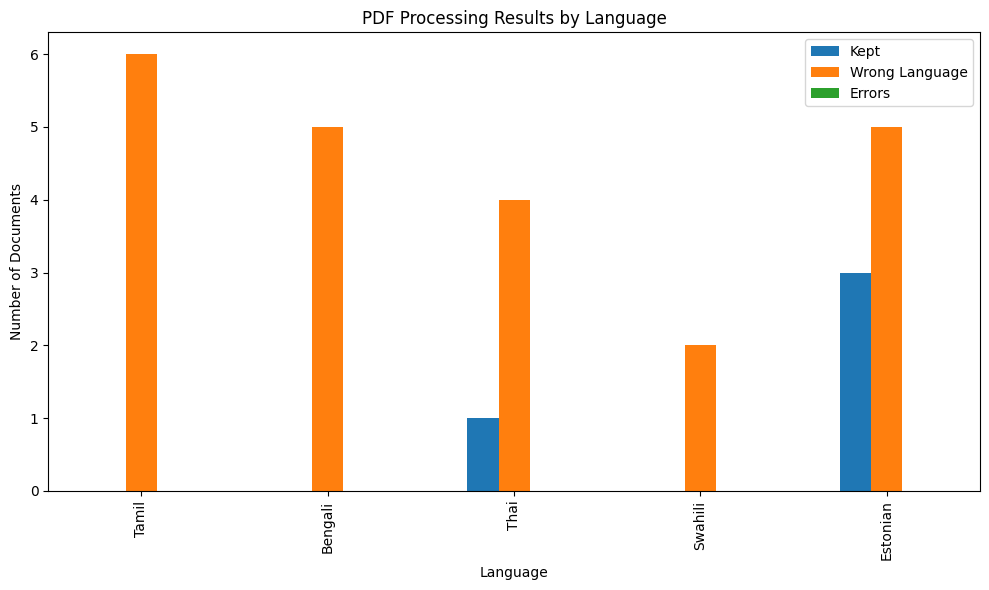

In [ ]:
processing_stats = []
detector = LanguageDetectorBuilder.from_all_languages().build()

for lang_code, config in LANGUAGES.items():
    lang_pdf_dir = PDFS_DIR / lang_code
    lang_extracted_dir = EXTRACTED_DIR / lang_code
    lang_extracted_dir.mkdir(parents=True, exist_ok=True)

    if not lang_pdf_dir.exists():
        continue

    pdf_files = list(lang_pdf_dir.glob("*.pdf"))
    kept_count = 0
    wrong_lang_count = 0
    error_count = 0

    for pdf_path in tqdm(
        pdf_files, total=len(pdf_files), desc=f"Processing {config['name']}"
    ):
        try:
            with pymupdf.open(str(pdf_path)) as doc:
                md_text = pymupdf4llm.to_markdown(doc)

            detected_code = detect_language(md_text, detector)
            if detected_code == lang_code:
                new_pdf_path = lang_pdf_dir / f"{kept_count}.pdf"
                pdf_path.rename(new_pdf_path)

                md_path = lang_extracted_dir / f"{kept_count}.md"
                md_path.write_text(md_text, encoding="utf-8")
                kept_count += 1
            else:
                pdf_path.unlink()
                wrong_lang_count += 1

        except Exception as e:
            pdf_path.unlink(missing_ok=True)
            error_count += 1

    processing_stats.append(
        {
            "Language": config["name"],
            "Total PDFs": len(pdf_files),
            "Kept": kept_count,
            "Wrong Language": wrong_lang_count,
            "Errors": error_count,
            "Success Rate": (
                f"{kept_count/len(pdf_files)*100:.1f}%" if pdf_files else "0%"
            ),
        }
    )

In [ ]:
stats_df = pd.DataFrame(processing_stats)
display(stats_df)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
stats_df.plot(x="Language", y=["Kept", "Wrong Language", "Errors"], kind="bar", ax=ax)
ax.set_title("PDF Processing Results by Language")
ax.set_ylabel("Number of Documents")
plt.tight_layout()
plt.show()

### Extract sentences


In [ ]:
extraction_stats = []
nlp = spacy.load("xx_ent_wiki_sm")
nlp.add_pipe("sentencizer")
detector = LanguageDetectorBuilder.from_all_languages().build()

for lang_code, config in LANGUAGES.items():
    lang_sents_file = SENTENCES_DIR / f"{lang_code}_sentences.jsonl"
    lang_extracted_dir = EXTRACTED_DIR / lang_code

    if not lang_extracted_dir.exists():
        continue

    markdown_files = list(lang_extracted_dir.glob("*.md"))
    total_sentences = 0

    with open(lang_sents_file, "w", encoding="utf-8") as out_file:
        for markdown_path in tqdm(
            markdown_files,
            total=len(markdown_files),
            desc=f"Extracting {config['name']}",
        ):
            try:
                md_text = markdown_path.read_text(encoding="utf-8")

                # Clean markdown text
                md_text = re.sub(r"```.*?```", "", md_text, flags=re.DOTALL)
                md_text = re.sub(r"\|.*?\|", "", md_text)
                md_text = re.sub(
                    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
                    "",
                    md_text,
                )

                doc = nlp(md_text)

                sentences = []
                for sent in doc.sents:
                    cleaned = clean_sentence(sent.text)
                    detected_code = detect_language(cleaned, detector)
                    if is_valid_sentence(cleaned) and detected_code == lang_code:
                        sentences.append(cleaned)

                for idx, sentence in enumerate(sentences):
                    data = {
                        "text": sentence,
                        "lang": lang_code,
                        "doc_id": markdown_path.stem,
                        "sent_id": idx,
                    }
                    out_file.write(json.dumps(data, ensure_ascii=False) + "\n")
                    total_sentences += 1

                    if total_sentences >= config["target_sentences"]:
                        break

            except Exception as e:
                print(f"Error when extracting sentences: {str(e)}")

        extraction_stats.append(
            {
                "Language": config["name"],
                "Code": lang_code,
                "Documents": len(markdown_files),
                "Sentences": total_sentences,
                "Avg per Doc": (
                    f"{total_sentences/len(markdown_files):.1f}"
                    if markdown_files
                    else "0"
                ),
            }
        )

Extracting Tamil: 0it [00:00, ?it/s]

Extracting Bengali: 0it [00:00, ?it/s]

Extracting Thai:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting Swahili: 0it [00:00, ?it/s]

Extracting Estonian:   0%|          | 0/3 [00:00<?, ?it/s]

,Language,Code,Documents,Sentences,Avg per Doc
0,Tamil,ta,0,0,0
1,Bengali,bn,0,0,0
2,Thai,th,1,6,6.0
3,Swahili,sw,0,0,0
4,Estonian,et,3,102,34.0


In [ ]:
stats_df = pd.DataFrame(extraction_stats)
display(stats_df)

In [14]:
dataset_statistics = []

for lang_code, config in LANGUAGES.items():
    lang_sents_file = SENTENCES_DIR / f"{lang_code}_sentences.jsonl"

    with open(lang_sents_file, "r", encoding="utf-8") as file:
        lang_sents = [json.loads(line) for line in file]

    if len(lang_sents) == 0:
        continue

    # Sentence lengths
    sent_lengths = [len(" ".join(sent["text"].split())) for sent in lang_sents]
    avg_sent_len = np.mean(sent_lengths)
    median_sent_len = np.median(sent_lengths)
    min_sent_len = np.min(sent_lengths)
    max_sent_len = np.max(sent_lengths)
    std_sent_len = np.std(sent_lengths)

    # Per-document stats
    per_doc_sents = {}
    for sent in lang_sents:
        per_doc_sents.setdefault(sent["doc_id"], []).append(sent)

    doc_ids = list(per_doc_sents.keys())
    avg_sent_per_doc = len(lang_sents) / len(doc_ids)
    doc_sentence_counts = [len(sents) for sents in per_doc_sents.values()]
    median_sent_per_doc = np.median(doc_sentence_counts)
    max_sent_per_doc = np.max(doc_sentence_counts)
    min_sent_per_doc = np.min(doc_sentence_counts)

    # Vocabulary stats
    words = " ".join([" ".join(sent["text"].split()) for sent in lang_sents]).split()
    vocab_size = len(set(words))
    top_words = Counter(words).most_common(10)

    dataset_statistics.append(
        {
            "Language": config["name"],
            "Code": lang_code,
            "Documents": len(doc_ids),
            "Sentences": len(lang_sents),
            "Avg Sentence Len": avg_sent_len,
            "Median Sentence Len": median_sent_len,
            "Min Sentence Len": min_sent_len,
            "Max Sentence Len": max_sent_len,
            "Std Sentence Len": std_sent_len,
            "Avg per Doc": avg_sent_per_doc,
            "Median per Doc": median_sent_per_doc,
            "Min per Doc": min_sent_per_doc,
            "Max per Doc": max_sent_per_doc,
            "Vocabulary Size": vocab_size,
            "Top Words": top_words,
        }
    )


In [ ]:
stats_df = pd.DataFrame(dataset_statistics)

display(stats_df[[
    "Language", "Documents", "Sentences", 
    "Avg Sentence Len", "Median Sentence Len", 
    "Min Sentence Len", "Max Sentence Len", 
    "Std Sentence Len", "Avg per Doc", 
    "Vocabulary Size"
]])

,Language,Documents,Sentences,Avg Sentence Len,Median Sentence Len,Min Sentence Len,Max Sentence Len,Std Sentence Len,Avg per Doc,Vocabulary Size
0,Thai,1,6,305.000000,310.0,128,416,93.813645,6.0,106
1,Estonian,3,102,125.813725,118.0,19,372,62.592164,34.0,1090


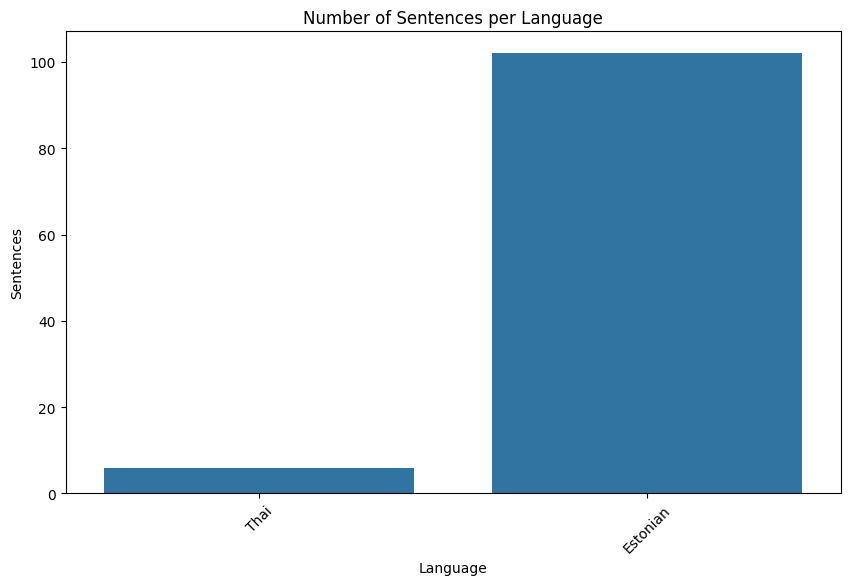

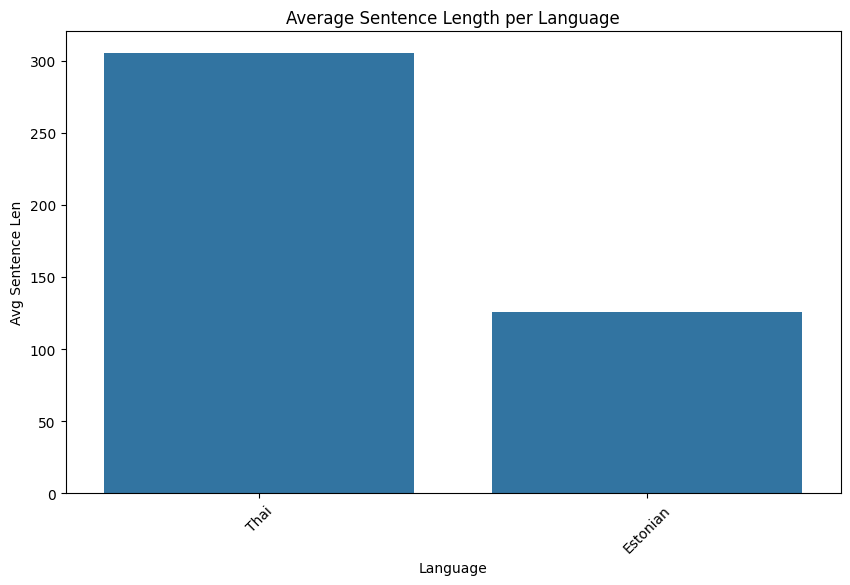

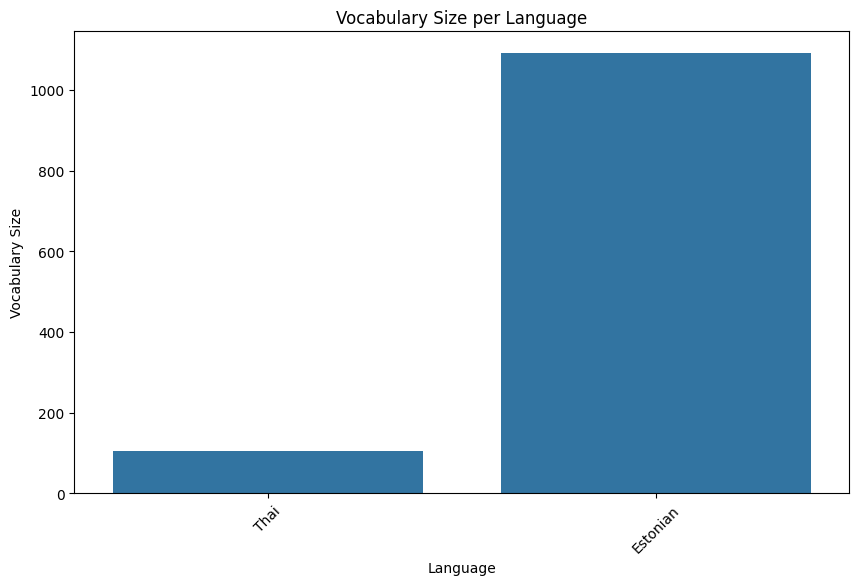

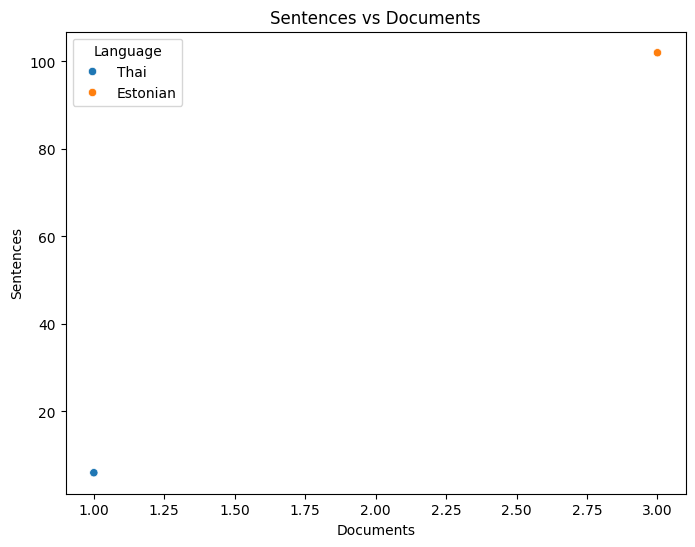

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot: number of sentences per language
plt.figure(figsize=(10,6))
sns.barplot(data=stats_df, x="Language", y="Sentences")
plt.title("Number of Sentences per Language")
plt.xticks(rotation=45)
plt.show()

# Bar plot: average sentence length per language
plt.figure(figsize=(10,6))
sns.barplot(data=stats_df, x="Language", y="Avg Sentence Len")
plt.title("Average Sentence Length per Language")
plt.xticks(rotation=45)
plt.show()

# Bar plot: vocabulary size per language
plt.figure(figsize=(10,6))
sns.barplot(data=stats_df, x="Language", y="Vocabulary Size")
plt.title("Vocabulary Size per Language")
plt.xticks(rotation=45)
plt.show()

# Scatter plot: sentences vs documents
plt.figure(figsize=(8,6))
sns.scatterplot(data=stats_df, x="Documents", y="Sentences", hue="Language")
plt.title("Sentences vs Documents")
plt.show()

### Back-translate

In [25]:
# Create batch input files for simple per-sentence translation
MODEL = "gpt-3.5-turbo-0125"
API_URL = "/v1/chat/completions"
SYS_PROMPT = "You are a helpful translator. Only respond with the translated text."

def prompt(sentence: str, lang_name: str) -> str:
    return f"Translate the following sentence into {lang_name}:\n{sentence}"

# Simple per-sentence translation
for lang_code, config in LANGUAGES.items():
    lang_sents_file = SENTENCES_DIR / f"{lang_code}_sentences.jsonl"
    lang_queries_file = API_QUERIES / f"{lang_code}_queries.jsonl"

    with open(lang_sents_file, "r", encoding="utf-8") as file:
        lang_sents = [json.loads(line) for line in file]

    queries = []

    with open(lang_queries_file, "w", encoding="utf-8") as out_file:

        for idx, sent in enumerate(lang_sents):
            query_id = f"{lang_code}_{idx}"
            messages = [{"role": "system", "content": SYS_PROMPT}, {"role": "user", "content": prompt(sent["text"], config["name"])}]
            query = {"custom_id": query_id, "method": "POST", "url": API_URL, "body": {"model": MODEL, "messages": messages,"max_tokens": 1000}}
            out_file.write(json.dumps(query, ensure_ascii=False) + "\n")


In [26]:
from openai import OpenAI
client = OpenAI()

for lang_code, config in LANGUAGES.items():
    lang_queries_file =  API_QUERIES / f"{lang_code}_queries.jsonl"
    batch_input_file = client.files.create(
        file=open(lang_queries_file, "rb"),
        purpose="batch"
    )

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable